### Machine Learning Model Development

1. Datasource:
    - https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

2. Objective:
    - To classify a person into abnormal or normal using collected physical spine data.
    
3. Encoding:
    - Normal = 0 | Abnormal(Patient) = 1
    
4. Metrics:
    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    - However, my focus would be to improve the overall accuracy as well.
    
5. Scope:
    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

6. Target:
    - Test Accuracy >= 90%
    - Recall >= 90%
    
7. Recommendation from Exploratory Data Analyses (EDA)
    - Drop pelvic_incidence
    - Use StandarScaler.
    - Downsampling / Upsampling.

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\Back_Pain_"

# Specify number of features and targets

n_features = 12
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

dropcol = ['lumbar_lordosis_angle', 'Direct_tilt', 'thoracic_slope', 'scoliosis_slope']

df=df.drop(columns=dropcol)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle,Class_att
0,47.806,10.689,37.117,125.391,-0.403,0.750,15.659,-4.137,Normal
1,92.026,35.393,56.634,115.724,58.058,0.302,11.212,-19.265,Patient
2,63.792,21.345,42.447,119.550,12.383,0.608,8.727,-8.842,Normal
3,46.390,11.079,35.311,98.775,6.387,0.065,7.302,-24.361,Patient
4,64.624,15.225,49.399,90.298,31.326,0.782,13.018,-20.526,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle,Class_att
0,47.806,10.689,37.117,125.391,-0.403,0.750,15.659,-4.137,0
1,92.026,35.393,56.634,115.724,58.058,0.302,11.212,-19.265,1
2,63.792,21.345,42.447,119.550,12.383,0.608,8.727,-8.842,0
3,46.390,11.079,35.311,98.775,6.387,0.065,7.302,-24.361,1
4,64.624,15.225,49.399,90.298,31.326,0.782,13.018,-20.526,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
cervical_tilt               0
sacrum_angle                0
Class_att                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
cervical_tilt               0
sacrum_angle                0
Class_att                   0
dtype: int64



In [15]:
# """
#     1. Cell for removing outliers.
#     2. Based on Z-score.
# """
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'cervical_tilt', 'sacrum_angle']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     310 |  60.497 | 17.237 |  26.148 |   46.43 |  58.692 |  72.878 | 129.834 |
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| cervical_tilt            |     310 |  11.933 |  2.893 |   7.031 |   9.541 |  11.954 |  14.372 |  16.821 |
| sacrum_angle             |

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    165
0     83
Name: Class_att, dtype: int64
After Upsampling: 0    165
1    165
Name: Class_att, dtype: int64


In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle
0,44.216,1.507,42.709,108.630,42.810,0.481,11.990,5.366
1,65.612,23.138,42.474,124.128,-4.083,0.997,13.391,-16.370
2,71.242,5.268,65.973,110.703,38.260,0.506,14.149,-19.896
3,56.564,8.961,47.603,98.777,50.702,0.589,12.466,0.744
4,72.344,16.421,55.923,70.083,12.073,0.057,9.368,-33.489


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle
119,76.147,21.936,54.211,123.932,10.432,0.253,11.071,-34.898
266,74.565,15.724,58.841,105.417,0.599,0.118,10.546,-32.495
217,83.703,20.268,63.435,125.480,69.280,0.736,14.381,-20.214
21,83.397,34.311,49.086,110.467,49.672,0.772,13.236,-21.450
61,78.426,33.426,45.000,138.554,77.155,0.581,7.965,-19.123


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Class_att
0,1
1,0
2,1
3,1
4,1


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Class_att
119,1
266,0
217,1
21,1
61,1


In [30]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle
0,-0.874219,-1.573776,0.071107,-0.867592,0.629782,0.081267,0.056061,1.586385
1,0.469767,0.727519,0.052016,0.363499,-0.680754,1.814718,0.527917,-0.153619
2,0.823414,-1.173648,1.960939,-0.702922,0.502621,0.165252,0.783211,-0.435882
3,-0.098582,-0.780754,0.468667,-1.650270,0.850343,0.444082,0.216377,1.216386
4,0.892636,0.012906,1.144535,-3.929591,-0.229237,-1.343119,-0.827028,-1.524025


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,pelvic_incidence,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,cervical_tilt,sacrum_angle
0,1.131521,0.599640,1.005462,0.347930,-0.275098,-0.684676,-0.253458,-1.636818
1,1.032148,-0.061247,1.381577,-1.122818,-0.549905,-1.138196,-0.430278,-1.444453
2,1.606150,0.422183,1.754767,0.470896,1.369549,0.937914,0.861349,-0.461338
3,1.586928,1.916200,0.589137,-0.721669,0.821557,1.058853,0.475713,-0.560282
4,1.274676,1.822046,0.257214,1.509435,1.589634,0.417207,-1.299558,-0.374002


In [35]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

Best: 0.937190 using {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937190 (0.029102) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937190 (0.029102) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937190 (0.029102) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
0.937068 (0.029158) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937068 (0.029158) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937068 (0.029158) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'liblinear'}
0.936762 (0.029549) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.2}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.936762 (0.029549) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.2}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.936762 (0.029549) wit

In [36]:
print("------ Logistic Regression Best Parameters")

------ Logistic Regression Best Parameters


In [37]:
LR_Best

{'C': 10000,
 'class_weight': {0: 1, 1: 1},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [38]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [39]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [40]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [41]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.68,0.76,0.72,17.00
1,0.91,0.87,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.82,0.80,62.00
weighted avg,0.85,0.84,0.84,62.00


In [42]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5, 2]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

Best: 0.959290 using {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.936884 (0.023113) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.938843 (0.021732) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.936823 (0.023525) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
0.938292 (0.021819) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.954209 (0.016254) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators':

In [43]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [44]:
RFC_Best

{'class_weight': {0: 1, 1: 1.05},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 600}

In [45]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [46]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [47]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [48]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.71,0.71,0.71,17.00
1,0.89,0.89,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.80,0.80,62.00
weighted avg,0.84,0.84,0.84,62.00


In [49]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [10000, 1000, 100]
gamma = [0.001, 0.01]
weights = [1.05, 1.5, 2]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

Best: 0.939210 using {'C': 100, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'rbf'}
0.936762 (0.029296) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.001, 'kernel': 'linear'}
0.937802 (0.026159) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.001, 'kernel': 'rbf'}
0.936762 (0.029296) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'linear'}
0.891582 (0.043398) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'rbf'}
0.935782 (0.030532) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'linear'}
0.931374 (0.027852) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'rbf'}
0.935782 (0.030532) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'linear'}
0.891215 (0.044611) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'rbf'}
0.935904 (0.029239) with: {'C': 10000, 'class_weight': {0: 

In [50]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [51]:
KSV_Best

{'C': 100, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'rbf'}

In [52]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [53]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [54]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [55]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.68,0.88,0.77,17.00
1,0.95,0.84,0.89,45.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.82,0.86,0.83,62.00
weighted avg,0.88,0.85,0.86,62.00


In [56]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.03, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [50, 100, 150]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_state=RND_STATE)

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

0:	test: 0.8942218	best: 0.8942218 (0)	total: 233ms	remaining: 11.4s
1:	test: 0.9175210	best: 0.9175210 (1)	total: 234ms	remaining: 5.63s
2:	test: 0.9165890	best: 0.9175210 (1)	total: 236ms	remaining: 3.69s
3:	test: 0.9091333	best: 0.9175210 (1)	total: 237ms	remaining: 2.72s
4:	test: 0.9100652	best: 0.9175210 (1)	total: 238ms	remaining: 2.14s
5:	test: 0.9063374	best: 0.9175210 (1)	total: 239ms	remaining: 1.75s
6:	test: 0.9021435	best: 0.9175210 (1)	total: 241ms	remaining: 1.48s
7:	test: 0.9002796	best: 0.9175210 (1)	total: 242ms	remaining: 1.27s
8:	test: 0.9273066	best: 0.9273066 (8)	total: 243ms	remaining: 1.11s
9:	test: 0.9310345	best: 0.9310345 (9)	total: 245ms	remaining: 978ms
10:	test: 0.9347623	best: 0.9347623 (10)	total: 246ms	remaining: 873ms
11:	test: 0.9403541	best: 0.9403541 (11)	total: 248ms	remaining: 784ms
12:	test: 0.9496738	best: 0.9496738 (12)	total: 249ms	remaining: 708ms
13:	test: 0.9496738	best: 0.9496738 (12)	total: 250ms	remaining: 642ms
14:	test: 0.9422181	best: 

45:	test: 0.9748369	best: 0.9757689 (43)	total: 51.6ms	remaining: 4.48ms
46:	test: 0.9757689	best: 0.9757689 (43)	total: 52.7ms	remaining: 3.37ms
47:	test: 0.9757689	best: 0.9757689 (43)	total: 53.7ms	remaining: 2.24ms
48:	test: 0.9776328	best: 0.9776328 (48)	total: 54.8ms	remaining: 1.12ms
49:	test: 0.9767008	best: 0.9776328 (48)	total: 55.9ms	remaining: 0us

bestTest = 0.9776328052
bestIteration = 48

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9776328	best: 0.9944082 (1)	total: 745ms	remaining: 12.7s
0:	test: 0.8932898	best: 0.8932898 (0)	total: 12.1ms	remaining: 595ms
1:	test: 0.9147251	best: 0.9147251 (1)	total: 13.3ms	remaining: 319ms
2:	test: 0.9082013	best: 0.9147251 (1)	total: 14.4ms	remaining: 226ms
3:	test: 0.9128611	best: 0.9147251 (1)	total: 15.8ms	remaining: 182ms
4:	test: 0.9189189	best: 0.9189189 (4)	total: 17.3ms	remaining: 156ms
5:	test: 0.9170550	best: 0.9189189 (4)	t

46:	test: 0.9832246	best: 0.9832246 (40)	total: 51.7ms	remaining: 3.3ms
47:	test: 0.9822926	best: 0.9832246 (40)	total: 52.8ms	remaining: 2.2ms
48:	test: 0.9832246	best: 0.9832246 (40)	total: 53.9ms	remaining: 1.1ms
49:	test: 0.9794967	best: 0.9832246 (40)	total: 55ms	remaining: 0us

bestTest = 0.9832246039
bestIteration = 40

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
5:	loss: 0.9832246	best: 0.9944082 (1)	total: 943ms	remaining: 7.54s
0:	test: 0.8942218	best: 0.8942218 (0)	total: 9.24ms	remaining: 915ms
1:	test: 0.9175210	best: 0.9175210 (1)	total: 10.4ms	remaining: 508ms
2:	test: 0.9165890	best: 0.9175210 (1)	total: 11.5ms	remaining: 370ms
3:	test: 0.9091333	best: 0.9175210 (1)	total: 12.5ms	remaining: 301ms
4:	test: 0.9100652	best: 0.9175210 (1)	total: 13.6ms	remaining: 258ms
5:	test: 0.9063374	best: 0.9175210 (1)	total: 14.7ms	remaining: 231ms
6:	test: 0.9021435	best: 0.9175210 (1)	total: 15

49:	test: 0.9944082	best: 0.9944082 (41)	total: 56.8ms	remaining: 56.8ms
50:	test: 0.9944082	best: 0.9944082 (41)	total: 58.1ms	remaining: 55.8ms
51:	test: 0.9925443	best: 0.9944082 (41)	total: 59.3ms	remaining: 54.7ms
52:	test: 0.9925443	best: 0.9944082 (41)	total: 60.3ms	remaining: 53.5ms
53:	test: 0.9925443	best: 0.9944082 (41)	total: 61.4ms	remaining: 52.3ms
54:	test: 0.9934762	best: 0.9944082 (41)	total: 62.5ms	remaining: 51.1ms
55:	test: 0.9934762	best: 0.9944082 (41)	total: 63.6ms	remaining: 50ms
56:	test: 0.9934762	best: 0.9944082 (41)	total: 64.7ms	remaining: 48.8ms
57:	test: 0.9934762	best: 0.9944082 (41)	total: 65.8ms	remaining: 47.6ms
58:	test: 0.9934762	best: 0.9944082 (41)	total: 66.9ms	remaining: 46.5ms
59:	test: 0.9934762	best: 0.9944082 (41)	total: 68ms	remaining: 45.3ms
60:	test: 0.9925443	best: 0.9944082 (41)	total: 69.1ms	remaining: 44.1ms
61:	test: 0.9925443	best: 0.9944082 (41)	total: 70.2ms	remaining: 43ms
62:	test: 0.9944082	best: 0.9944082 (41)	total: 71.2ms	re

35:	test: 0.9776328	best: 0.9794967 (30)	total: 33.1ms	remaining: 58.9ms
36:	test: 0.9794967	best: 0.9794967 (30)	total: 34.2ms	remaining: 58.2ms
37:	test: 0.9785648	best: 0.9794967 (30)	total: 35.5ms	remaining: 58ms
38:	test: 0.9785648	best: 0.9794967 (30)	total: 36.7ms	remaining: 57.3ms
39:	test: 0.9794967	best: 0.9794967 (30)	total: 37.8ms	remaining: 56.6ms
40:	test: 0.9794967	best: 0.9794967 (30)	total: 38.8ms	remaining: 55.9ms
41:	test: 0.9804287	best: 0.9804287 (41)	total: 39.9ms	remaining: 55.1ms
42:	test: 0.9804287	best: 0.9804287 (41)	total: 40.9ms	remaining: 54.2ms
43:	test: 0.9794967	best: 0.9804287 (41)	total: 42ms	remaining: 53.4ms
44:	test: 0.9813607	best: 0.9813607 (44)	total: 43ms	remaining: 52.6ms
45:	test: 0.9813607	best: 0.9813607 (44)	total: 44.2ms	remaining: 51.9ms
46:	test: 0.9841566	best: 0.9841566 (46)	total: 45.2ms	remaining: 51ms
47:	test: 0.9841566	best: 0.9841566 (46)	total: 46.3ms	remaining: 50.2ms
48:	test: 0.9850885	best: 0.9850885 (48)	total: 47.4ms	rema

7:	test: 0.9179870	best: 0.9207829 (6)	total: 8.07ms	remaining: 92.8ms
8:	test: 0.9356943	best: 0.9356943 (8)	total: 9.33ms	remaining: 94.3ms
9:	test: 0.9347623	best: 0.9356943 (8)	total: 10.6ms	remaining: 95.3ms
10:	test: 0.9487418	best: 0.9487418 (10)	total: 11.7ms	remaining: 94.6ms
11:	test: 0.9599254	best: 0.9599254 (11)	total: 12.9ms	remaining: 94.6ms
12:	test: 0.9552656	best: 0.9599254 (11)	total: 14ms	remaining: 93.5ms
13:	test: 0.9627213	best: 0.9627213 (13)	total: 15ms	remaining: 92.2ms
14:	test: 0.9627213	best: 0.9627213 (13)	total: 16ms	remaining: 90.9ms
15:	test: 0.9664492	best: 0.9664492 (15)	total: 17.1ms	remaining: 89.7ms
16:	test: 0.9692451	best: 0.9692451 (16)	total: 18.1ms	remaining: 88.6ms
17:	test: 0.9683131	best: 0.9692451 (16)	total: 19.2ms	remaining: 87.5ms
18:	test: 0.9711090	best: 0.9711090 (18)	total: 20.3ms	remaining: 86.6ms
19:	test: 0.9711090	best: 0.9711090 (18)	total: 21.4ms	remaining: 85.6ms
20:	test: 0.9739049	best: 0.9739049 (20)	total: 22.4ms	remainin

25:	test: 0.9729730	best: 0.9748369 (24)	total: 60.5ms	remaining: 289ms
26:	test: 0.9757689	best: 0.9757689 (26)	total: 61.8ms	remaining: 281ms
27:	test: 0.9767008	best: 0.9767008 (27)	total: 62.9ms	remaining: 274ms
28:	test: 0.9767008	best: 0.9767008 (27)	total: 64ms	remaining: 267ms
29:	test: 0.9794967	best: 0.9794967 (29)	total: 65ms	remaining: 260ms
30:	test: 0.9804287	best: 0.9804287 (30)	total: 66ms	remaining: 254ms
31:	test: 0.9804287	best: 0.9804287 (30)	total: 67.7ms	remaining: 250ms
32:	test: 0.9822926	best: 0.9822926 (32)	total: 68.9ms	remaining: 244ms
33:	test: 0.9804287	best: 0.9822926 (32)	total: 70ms	remaining: 239ms
34:	test: 0.9804287	best: 0.9822926 (32)	total: 71.2ms	remaining: 234ms
35:	test: 0.9804287	best: 0.9822926 (32)	total: 72.4ms	remaining: 229ms
36:	test: 0.9832246	best: 0.9832246 (36)	total: 73.6ms	remaining: 225ms
37:	test: 0.9813607	best: 0.9832246 (36)	total: 74.7ms	remaining: 220ms
38:	test: 0.9850885	best: 0.9850885 (38)	total: 75.8ms	remaining: 216ms


41:	test: 0.9944082	best: 0.9944082 (41)	total: 38.2ms	remaining: 98.1ms
42:	test: 0.9944082	best: 0.9944082 (41)	total: 39.3ms	remaining: 97.7ms
43:	test: 0.9944082	best: 0.9944082 (41)	total: 40.5ms	remaining: 97.5ms
44:	test: 0.9944082	best: 0.9944082 (41)	total: 41.6ms	remaining: 97.1ms
45:	test: 0.9944082	best: 0.9944082 (41)	total: 42.7ms	remaining: 96.5ms
46:	test: 0.9944082	best: 0.9944082 (41)	total: 43.8ms	remaining: 95.9ms
47:	test: 0.9944082	best: 0.9944082 (41)	total: 44.8ms	remaining: 95.2ms
48:	test: 0.9944082	best: 0.9944082 (41)	total: 45.9ms	remaining: 94.5ms
49:	test: 0.9944082	best: 0.9944082 (41)	total: 46.9ms	remaining: 93.8ms
50:	test: 0.9944082	best: 0.9944082 (41)	total: 48ms	remaining: 93.1ms
51:	test: 0.9925443	best: 0.9944082 (41)	total: 49ms	remaining: 92.4ms
52:	test: 0.9925443	best: 0.9944082 (41)	total: 50.1ms	remaining: 91.8ms
53:	test: 0.9925443	best: 0.9944082 (41)	total: 51.2ms	remaining: 91.1ms
54:	test: 0.9934762	best: 0.9944082 (41)	total: 52.3ms	

75:	test: 0.9785648	best: 0.9804287 (55)	total: 70.5ms	remaining: 68.6ms
76:	test: 0.9785648	best: 0.9804287 (55)	total: 71.6ms	remaining: 67.9ms
77:	test: 0.9785648	best: 0.9804287 (55)	total: 72.8ms	remaining: 67.2ms
78:	test: 0.9785648	best: 0.9804287 (55)	total: 73.9ms	remaining: 66.4ms
79:	test: 0.9785648	best: 0.9804287 (55)	total: 75ms	remaining: 65.7ms
80:	test: 0.9804287	best: 0.9804287 (55)	total: 76.1ms	remaining: 64.8ms
81:	test: 0.9804287	best: 0.9804287 (55)	total: 77.1ms	remaining: 63.9ms
82:	test: 0.9804287	best: 0.9804287 (55)	total: 78.1ms	remaining: 63.1ms
83:	test: 0.9804287	best: 0.9804287 (55)	total: 79.2ms	remaining: 62.2ms
84:	test: 0.9785648	best: 0.9804287 (55)	total: 80.2ms	remaining: 61.4ms
85:	test: 0.9794967	best: 0.9804287 (55)	total: 81.3ms	remaining: 60.5ms
86:	test: 0.9813607	best: 0.9813607 (86)	total: 82.3ms	remaining: 59.6ms
87:	test: 0.9822926	best: 0.9822926 (87)	total: 83.4ms	remaining: 58.7ms
88:	test: 0.9841566	best: 0.9841566 (88)	total: 84.4m

125:	test: 0.9897484	best: 0.9925443 (87)	total: 114ms	remaining: 21.7ms
126:	test: 0.9916123	best: 0.9925443 (87)	total: 115ms	remaining: 20.8ms
127:	test: 0.9916123	best: 0.9925443 (87)	total: 116ms	remaining: 20ms
128:	test: 0.9916123	best: 0.9925443 (87)	total: 118ms	remaining: 19.1ms
129:	test: 0.9916123	best: 0.9925443 (87)	total: 119ms	remaining: 18.3ms
130:	test: 0.9916123	best: 0.9925443 (87)	total: 120ms	remaining: 17.4ms
131:	test: 0.9916123	best: 0.9925443 (87)	total: 121ms	remaining: 16.5ms
132:	test: 0.9916123	best: 0.9925443 (87)	total: 122ms	remaining: 15.6ms
133:	test: 0.9916123	best: 0.9925443 (87)	total: 123ms	remaining: 14.7ms
134:	test: 0.9916123	best: 0.9925443 (87)	total: 124ms	remaining: 13.8ms
135:	test: 0.9916123	best: 0.9925443 (87)	total: 125ms	remaining: 12.9ms
136:	test: 0.9916123	best: 0.9925443 (87)	total: 126ms	remaining: 12ms
137:	test: 0.9916123	best: 0.9925443 (87)	total: 127ms	remaining: 11.1ms
138:	test: 0.9916123	best: 0.9925443 (87)	total: 128ms	

7:	test: 0.9179870	best: 0.9207829 (6)	total: 8.04ms	remaining: 143ms
8:	test: 0.9356943	best: 0.9356943 (8)	total: 9.25ms	remaining: 145ms
9:	test: 0.9347623	best: 0.9356943 (8)	total: 10.4ms	remaining: 146ms
10:	test: 0.9487418	best: 0.9487418 (10)	total: 11.5ms	remaining: 146ms
11:	test: 0.9599254	best: 0.9599254 (11)	total: 12.7ms	remaining: 146ms
12:	test: 0.9552656	best: 0.9599254 (11)	total: 13.8ms	remaining: 145ms
13:	test: 0.9627213	best: 0.9627213 (13)	total: 14.8ms	remaining: 144ms
14:	test: 0.9627213	best: 0.9627213 (13)	total: 15.9ms	remaining: 143ms
15:	test: 0.9664492	best: 0.9664492 (15)	total: 16.9ms	remaining: 142ms
16:	test: 0.9692451	best: 0.9692451 (16)	total: 17.9ms	remaining: 140ms
17:	test: 0.9683131	best: 0.9692451 (16)	total: 19ms	remaining: 139ms
18:	test: 0.9711090	best: 0.9711090 (18)	total: 20.1ms	remaining: 138ms
19:	test: 0.9711090	best: 0.9711090 (18)	total: 21.1ms	remaining: 137ms
20:	test: 0.9739049	best: 0.9739049 (20)	total: 22.3ms	remaining: 137ms


21:	test: 0.9664492	best: 0.9729730 (19)	total: 40.2ms	remaining: 51.1ms
22:	test: 0.9683131	best: 0.9729730 (19)	total: 42.3ms	remaining: 49.6ms
23:	test: 0.9683131	best: 0.9729730 (19)	total: 43.8ms	remaining: 47.5ms
24:	test: 0.9664492	best: 0.9729730 (19)	total: 45.8ms	remaining: 45.8ms
25:	test: 0.9673812	best: 0.9729730 (19)	total: 47.6ms	remaining: 43.9ms
26:	test: 0.9673812	best: 0.9729730 (19)	total: 49.4ms	remaining: 42.1ms
27:	test: 0.9673812	best: 0.9729730 (19)	total: 51.2ms	remaining: 40.3ms
28:	test: 0.9692451	best: 0.9729730 (19)	total: 53.1ms	remaining: 38.5ms
29:	test: 0.9692451	best: 0.9729730 (19)	total: 55.1ms	remaining: 36.7ms
30:	test: 0.9701771	best: 0.9729730 (19)	total: 56.9ms	remaining: 34.9ms
31:	test: 0.9701771	best: 0.9729730 (19)	total: 58.9ms	remaining: 33.1ms
32:	test: 0.9767008	best: 0.9767008 (32)	total: 60.8ms	remaining: 31.3ms
33:	test: 0.9785648	best: 0.9785648 (33)	total: 62.8ms	remaining: 29.5ms
34:	test: 0.9767008	best: 0.9785648 (33)	total: 64.

41:	test: 0.9804287	best: 0.9804287 (38)	total: 71.5ms	remaining: 13.6ms
42:	test: 0.9822926	best: 0.9822926 (42)	total: 73.5ms	remaining: 12ms
43:	test: 0.9813607	best: 0.9822926 (42)	total: 75.4ms	remaining: 10.3ms
44:	test: 0.9813607	best: 0.9822926 (42)	total: 77.3ms	remaining: 8.58ms
45:	test: 0.9813607	best: 0.9822926 (42)	total: 79.1ms	remaining: 6.88ms
46:	test: 0.9813607	best: 0.9822926 (42)	total: 81ms	remaining: 5.17ms
47:	test: 0.9813607	best: 0.9822926 (42)	total: 83ms	remaining: 3.46ms
48:	test: 0.9813607	best: 0.9822926 (42)	total: 86ms	remaining: 1.75ms
49:	test: 0.9813607	best: 0.9822926 (42)	total: 87.9ms	remaining: 0us

bestTest = 0.9822926375
bestIteration = 42

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
21:	loss: 0.9822926	best: 1.0000000 (7)	total: 3.01s	remaining: 4.37s
0:	test: 0.8811743	best: 0.8811743 (0)	total: 2.29ms	remaining: 112ms
1:	test: 0.9030755	best: 0.9030755 

93:	test: 0.9869525	best: 0.9869525 (92)	total: 167ms	remaining: 10.7ms
94:	test: 0.9869525	best: 0.9869525 (92)	total: 169ms	remaining: 8.92ms
95:	test: 0.9869525	best: 0.9869525 (92)	total: 171ms	remaining: 7.12ms
96:	test: 0.9869525	best: 0.9869525 (92)	total: 173ms	remaining: 5.34ms
97:	test: 0.9869525	best: 0.9869525 (92)	total: 174ms	remaining: 3.55ms
98:	test: 0.9878844	best: 0.9878844 (98)	total: 175ms	remaining: 1.77ms
99:	test: 0.9878844	best: 0.9878844 (98)	total: 177ms	remaining: 0us

bestTest = 0.9878844362
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.9878844	best: 1.0000000 (7)	total: 3.37s	remaining: 3.91s
0:	test: 0.8853681	best: 0.8853681 (0)	total: 13.4ms	remaining: 1.32s
1:	test: 0.8974837	best: 0.8974837 (1)	total: 15ms	remaining: 733ms
2:	test: 0.8835042	best: 0.8974837 (1)	total: 16.5ms	remaining: 534ms
3:	test: 0.9254427	best: 0.9254427 (3)	tot

74:	test: 0.9841566	best: 0.9850885 (72)	total: 146ms	remaining: 48.5ms
75:	test: 0.9850885	best: 0.9850885 (72)	total: 147ms	remaining: 46.6ms
76:	test: 0.9850885	best: 0.9850885 (72)	total: 149ms	remaining: 44.5ms
77:	test: 0.9850885	best: 0.9850885 (72)	total: 151ms	remaining: 42.6ms
78:	test: 0.9850885	best: 0.9850885 (72)	total: 153ms	remaining: 40.7ms
79:	test: 0.9850885	best: 0.9850885 (72)	total: 155ms	remaining: 38.7ms
80:	test: 0.9850885	best: 0.9850885 (72)	total: 158ms	remaining: 37ms
81:	test: 0.9850885	best: 0.9850885 (72)	total: 160ms	remaining: 35.2ms
82:	test: 0.9850885	best: 0.9850885 (72)	total: 162ms	remaining: 33.2ms
83:	test: 0.9850885	best: 0.9850885 (72)	total: 164ms	remaining: 31.3ms
84:	test: 0.9850885	best: 0.9850885 (72)	total: 166ms	remaining: 29.3ms
85:	test: 0.9850885	best: 0.9850885 (72)	total: 168ms	remaining: 27.4ms
86:	test: 0.9850885	best: 0.9850885 (72)	total: 170ms	remaining: 25.4ms
87:	test: 0.9860205	best: 0.9860205 (87)	total: 172ms	remaining: 2

78:	test: 0.9832246	best: 0.9832246 (78)	total: 131ms	remaining: 34.7ms
79:	test: 0.9832246	best: 0.9832246 (78)	total: 133ms	remaining: 33.2ms
80:	test: 0.9832246	best: 0.9832246 (78)	total: 135ms	remaining: 31.6ms
81:	test: 0.9832246	best: 0.9832246 (78)	total: 136ms	remaining: 29.9ms
82:	test: 0.9832246	best: 0.9832246 (78)	total: 138ms	remaining: 28.3ms
83:	test: 0.9832246	best: 0.9832246 (78)	total: 140ms	remaining: 26.7ms
84:	test: 0.9832246	best: 0.9832246 (78)	total: 142ms	remaining: 25.1ms
85:	test: 0.9832246	best: 0.9832246 (78)	total: 145ms	remaining: 23.7ms
86:	test: 0.9832246	best: 0.9832246 (78)	total: 147ms	remaining: 22ms
87:	test: 0.9832246	best: 0.9832246 (78)	total: 149ms	remaining: 20.4ms
88:	test: 0.9832246	best: 0.9832246 (78)	total: 151ms	remaining: 18.7ms
89:	test: 0.9832246	best: 0.9832246 (78)	total: 153ms	remaining: 17ms
90:	test: 0.9832246	best: 0.9832246 (78)	total: 155ms	remaining: 15.3ms
91:	test: 0.9841566	best: 0.9841566 (91)	total: 156ms	remaining: 13.

bestTest = 0.9888164026
bestIteration = 73

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
29:	loss: 0.9888164	best: 1.0000000 (7)	total: 4.3s	remaining: 3.44s
0:	test: 0.8853681	best: 0.8853681 (0)	total: 2.38ms	remaining: 354ms
1:	test: 0.8872321	best: 0.8872321 (1)	total: 4.29ms	remaining: 317ms
2:	test: 0.8853681	best: 0.8872321 (1)	total: 6.19ms	remaining: 303ms
3:	test: 0.9245107	best: 0.9245107 (3)	total: 8.07ms	remaining: 295ms
4:	test: 0.9291705	best: 0.9291705 (4)	total: 10ms	remaining: 290ms
5:	test: 0.9422181	best: 0.9422181 (5)	total: 11.9ms	remaining: 286ms
6:	test: 0.9487418	best: 0.9487418 (6)	total: 13.8ms	remaining: 283ms
7:	test: 0.9506058	best: 0.9506058 (7)	total: 15.8ms	remaining: 280ms
8:	test: 0.9422181	best: 0.9506058 (7)	total: 17.7ms	remaining: 277ms
9:	test: 0.9450140	best: 0.9506058 (7)	total: 19.7ms	remaining: 275ms
10:	test: 0.9431500	best: 0.9506058 (7)	total: 21.7ms	r

120:	test: 0.9878844	best: 0.9888164 (109)	total: 178ms	remaining: 42.6ms
121:	test: 0.9878844	best: 0.9888164 (109)	total: 180ms	remaining: 41.2ms
122:	test: 0.9878844	best: 0.9888164 (109)	total: 182ms	remaining: 39.9ms
123:	test: 0.9878844	best: 0.9888164 (109)	total: 183ms	remaining: 38.5ms
124:	test: 0.9878844	best: 0.9888164 (109)	total: 185ms	remaining: 37.1ms
125:	test: 0.9878844	best: 0.9888164 (109)	total: 187ms	remaining: 35.7ms
126:	test: 0.9878844	best: 0.9888164 (109)	total: 189ms	remaining: 34.3ms
127:	test: 0.9878844	best: 0.9888164 (109)	total: 191ms	remaining: 32.8ms
128:	test: 0.9878844	best: 0.9888164 (109)	total: 193ms	remaining: 31.4ms
129:	test: 0.9878844	best: 0.9888164 (109)	total: 195ms	remaining: 30ms
130:	test: 0.9888164	best: 0.9888164 (109)	total: 197ms	remaining: 28.6ms
131:	test: 0.9888164	best: 0.9888164 (109)	total: 199ms	remaining: 27.2ms
132:	test: 0.9888164	best: 0.9888164 (109)	total: 201ms	remaining: 25.7ms
133:	test: 0.9888164	best: 0.9888164 (10

88:	test: 0.9869525	best: 0.9888164 (69)	total: 126ms	remaining: 86.7ms
89:	test: 0.9869525	best: 0.9888164 (69)	total: 129ms	remaining: 85.7ms
90:	test: 0.9869525	best: 0.9888164 (69)	total: 131ms	remaining: 84.7ms
91:	test: 0.9869525	best: 0.9888164 (69)	total: 132ms	remaining: 83.5ms
92:	test: 0.9869525	best: 0.9888164 (69)	total: 134ms	remaining: 82.3ms
93:	test: 0.9869525	best: 0.9888164 (69)	total: 136ms	remaining: 81.2ms
94:	test: 0.9869525	best: 0.9888164 (69)	total: 138ms	remaining: 80ms
95:	test: 0.9869525	best: 0.9888164 (69)	total: 140ms	remaining: 78.9ms
96:	test: 0.9869525	best: 0.9888164 (69)	total: 142ms	remaining: 77.6ms
97:	test: 0.9869525	best: 0.9888164 (69)	total: 144ms	remaining: 76.5ms
98:	test: 0.9869525	best: 0.9888164 (69)	total: 146ms	remaining: 75.2ms
99:	test: 0.9869525	best: 0.9888164 (69)	total: 148ms	remaining: 73.8ms
100:	test: 0.9869525	best: 0.9888164 (69)	total: 149ms	remaining: 72.4ms
101:	test: 0.9869525	best: 0.9888164 (69)	total: 151ms	remaining:

53:	test: 0.9813607	best: 0.9822926 (47)	total: 84.1ms	remaining: 149ms
54:	test: 0.9813607	best: 0.9822926 (47)	total: 86.2ms	remaining: 149ms
55:	test: 0.9813607	best: 0.9822926 (47)	total: 89.3ms	remaining: 150ms
56:	test: 0.9822926	best: 0.9822926 (47)	total: 91.2ms	remaining: 149ms
57:	test: 0.9822926	best: 0.9822926 (47)	total: 93.1ms	remaining: 148ms
58:	test: 0.9822926	best: 0.9822926 (47)	total: 95ms	remaining: 147ms
59:	test: 0.9813607	best: 0.9822926 (47)	total: 96.9ms	remaining: 145ms
60:	test: 0.9822926	best: 0.9822926 (47)	total: 98.8ms	remaining: 144ms
61:	test: 0.9813607	best: 0.9822926 (47)	total: 101ms	remaining: 143ms
62:	test: 0.9832246	best: 0.9832246 (62)	total: 103ms	remaining: 142ms
63:	test: 0.9832246	best: 0.9832246 (62)	total: 105ms	remaining: 141ms
64:	test: 0.9832246	best: 0.9832246 (62)	total: 106ms	remaining: 139ms
65:	test: 0.9832246	best: 0.9832246 (62)	total: 108ms	remaining: 137ms
66:	test: 0.9832246	best: 0.9832246 (62)	total: 109ms	remaining: 135ms


143:	test: 0.9869525	best: 0.9869525 (101)	total: 223ms	remaining: 9.3ms
144:	test: 0.9869525	best: 0.9869525 (101)	total: 225ms	remaining: 7.77ms
145:	test: 0.9869525	best: 0.9869525 (101)	total: 227ms	remaining: 6.22ms
146:	test: 0.9869525	best: 0.9869525 (101)	total: 229ms	remaining: 4.67ms
147:	test: 0.9869525	best: 0.9869525 (101)	total: 231ms	remaining: 3.12ms
148:	test: 0.9869525	best: 0.9869525 (101)	total: 233ms	remaining: 1.56ms
149:	test: 0.9869525	best: 0.9869525 (101)	total: 235ms	remaining: 0us

bestTest = 0.9869524697
bestIteration = 101

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.9869525	best: 1.0000000 (7)	total: 5.26s	remaining: 3.09s
0:	test: 0.8811743	best: 0.8811743 (0)	total: 17.5ms	remaining: 2.61s
1:	test: 0.9030755	best: 0.9030755 (1)	total: 19.1ms	remaining: 1.42s
2:	test: 0.8904939	best: 0.9030755 (1)	total: 20.8ms	remaining: 1.02s
3:	test: 0.9291705	best: 0

111:	test: 0.9841566	best: 0.9841566 (91)	total: 177ms	remaining: 60ms
112:	test: 0.9841566	best: 0.9841566 (91)	total: 179ms	remaining: 58.6ms
113:	test: 0.9841566	best: 0.9841566 (91)	total: 181ms	remaining: 57.1ms
114:	test: 0.9841566	best: 0.9841566 (91)	total: 183ms	remaining: 55.6ms
115:	test: 0.9841566	best: 0.9841566 (91)	total: 185ms	remaining: 54.1ms
116:	test: 0.9841566	best: 0.9841566 (91)	total: 187ms	remaining: 52.6ms
117:	test: 0.9841566	best: 0.9841566 (91)	total: 188ms	remaining: 51.1ms
118:	test: 0.9841566	best: 0.9841566 (91)	total: 190ms	remaining: 49.6ms
119:	test: 0.9841566	best: 0.9841566 (91)	total: 192ms	remaining: 48.1ms
120:	test: 0.9841566	best: 0.9841566 (91)	total: 194ms	remaining: 46.6ms
121:	test: 0.9841566	best: 0.9841566 (91)	total: 196ms	remaining: 45ms
122:	test: 0.9841566	best: 0.9841566 (91)	total: 198ms	remaining: 43.5ms
123:	test: 0.9850885	best: 0.9850885 (123)	total: 200ms	remaining: 41.9ms
124:	test: 0.9841566	best: 0.9850885 (123)	total: 201m

74:	test: 0.9878844	best: 0.9888164 (73)	total: 114ms	remaining: 114ms
75:	test: 0.9860205	best: 0.9888164 (73)	total: 116ms	remaining: 113ms
76:	test: 0.9860205	best: 0.9888164 (73)	total: 118ms	remaining: 112ms
77:	test: 0.9850885	best: 0.9888164 (73)	total: 120ms	remaining: 111ms
78:	test: 0.9888164	best: 0.9888164 (73)	total: 122ms	remaining: 110ms
79:	test: 0.9888164	best: 0.9888164 (73)	total: 124ms	remaining: 108ms
80:	test: 0.9888164	best: 0.9888164 (73)	total: 126ms	remaining: 107ms
81:	test: 0.9878844	best: 0.9888164 (73)	total: 128ms	remaining: 106ms
82:	test: 0.9878844	best: 0.9888164 (73)	total: 130ms	remaining: 105ms
83:	test: 0.9878844	best: 0.9888164 (73)	total: 132ms	remaining: 104ms
84:	test: 0.9878844	best: 0.9888164 (73)	total: 134ms	remaining: 102ms
85:	test: 0.9878844	best: 0.9888164 (73)	total: 135ms	remaining: 101ms
86:	test: 0.9860205	best: 0.9888164 (73)	total: 137ms	remaining: 99.3ms
87:	test: 0.9860205	best: 0.9888164 (73)	total: 139ms	remaining: 97.6ms
88:	

38:	test: 0.9934762	best: 0.9934762 (36)	total: 744ms	remaining: 210ms
39:	test: 0.9934762	best: 0.9934762 (36)	total: 764ms	remaining: 191ms
40:	test: 0.9944082	best: 0.9944082 (40)	total: 790ms	remaining: 173ms
41:	test: 0.9934762	best: 0.9944082 (40)	total: 808ms	remaining: 154ms
42:	test: 0.9962721	best: 0.9962721 (42)	total: 827ms	remaining: 135ms
43:	test: 0.9953402	best: 0.9962721 (42)	total: 847ms	remaining: 116ms
44:	test: 0.9962721	best: 0.9962721 (42)	total: 872ms	remaining: 96.8ms
45:	test: 0.9944082	best: 0.9962721 (42)	total: 890ms	remaining: 77.4ms
46:	test: 0.9925443	best: 0.9962721 (42)	total: 907ms	remaining: 57.9ms
47:	test: 0.9934762	best: 0.9962721 (42)	total: 925ms	remaining: 38.6ms
48:	test: 0.9972041	best: 0.9972041 (48)	total: 951ms	remaining: 19.4ms
49:	test: 0.9972041	best: 0.9972041 (48)	total: 971ms	remaining: 0us

bestTest = 0.9972041007
bestIteration = 48

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_

47:	test: 0.9953402	best: 0.9972041 (34)	total: 938ms	remaining: 39.1ms
48:	test: 0.9962721	best: 0.9972041 (34)	total: 956ms	remaining: 19.5ms
49:	test: 0.9962721	best: 0.9972041 (34)	total: 974ms	remaining: 0us

bestTest = 0.9972041007
bestIteration = 34

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
38:	loss: 0.9972041	best: 1.0000000 (7)	total: 8.74s	remaining: 3.36s
0:	test: 0.9068034	best: 0.9068034 (0)	total: 20.4ms	remaining: 1s
1:	test: 0.9212488	best: 0.9212488 (1)	total: 38.5ms	remaining: 924ms
2:	test: 0.9589935	best: 0.9589935 (2)	total: 56.8ms	remaining: 889ms
3:	test: 0.9739049	best: 0.9739049 (3)	total: 80.6ms	remaining: 927ms
4:	test: 0.9664492	best: 0.9739049 (3)	total: 98.6ms	remaining: 887ms
5:	test: 0.9767008	best: 0.9767008 (5)	total: 117ms	remaining: 856ms
6:	test: 0.9832246	best: 0.9832246 (6)	total: 135ms	remaining: 827ms
7:	test: 0.9776328	best: 0.9832246 (6)	total: 157ms	r

7:	test: 0.9599254	best: 0.9692451 (3)	total: 153ms	remaining: 804ms
8:	test: 0.9673812	best: 0.9692451 (3)	total: 171ms	remaining: 780ms
9:	test: 0.9645853	best: 0.9692451 (3)	total: 189ms	remaining: 754ms
10:	test: 0.9655172	best: 0.9692451 (3)	total: 206ms	remaining: 730ms
11:	test: 0.9636533	best: 0.9692451 (3)	total: 224ms	remaining: 709ms
12:	test: 0.9720410	best: 0.9720410 (12)	total: 242ms	remaining: 688ms
13:	test: 0.9729730	best: 0.9729730 (13)	total: 262ms	remaining: 674ms
14:	test: 0.9794967	best: 0.9794967 (14)	total: 281ms	remaining: 656ms
15:	test: 0.9794967	best: 0.9794967 (14)	total: 299ms	remaining: 636ms
16:	test: 0.9785648	best: 0.9794967 (14)	total: 321ms	remaining: 623ms
17:	test: 0.9785648	best: 0.9794967 (14)	total: 341ms	remaining: 607ms
18:	test: 0.9776328	best: 0.9794967 (14)	total: 358ms	remaining: 584ms
19:	test: 0.9794967	best: 0.9794967 (14)	total: 382ms	remaining: 573ms
20:	test: 0.9860205	best: 0.9860205 (20)	total: 400ms	remaining: 553ms
21:	test: 0.98

74:	test: 0.9962721	best: 0.9972041 (48)	total: 1.38s	remaining: 460ms
75:	test: 0.9962721	best: 0.9972041 (48)	total: 1.4s	remaining: 441ms
76:	test: 0.9962721	best: 0.9972041 (48)	total: 1.41s	remaining: 422ms
77:	test: 0.9962721	best: 0.9972041 (48)	total: 1.44s	remaining: 405ms
78:	test: 0.9962721	best: 0.9972041 (48)	total: 1.45s	remaining: 386ms
79:	test: 0.9962721	best: 0.9972041 (48)	total: 1.47s	remaining: 367ms
80:	test: 0.9962721	best: 0.9972041 (48)	total: 1.48s	remaining: 346ms
81:	test: 0.9962721	best: 0.9972041 (48)	total: 1.49s	remaining: 328ms
82:	test: 0.9962721	best: 0.9972041 (48)	total: 1.51s	remaining: 310ms
83:	test: 0.9962721	best: 0.9972041 (48)	total: 1.53s	remaining: 292ms
84:	test: 0.9962721	best: 0.9972041 (48)	total: 1.55s	remaining: 273ms
85:	test: 0.9962721	best: 0.9972041 (48)	total: 1.56s	remaining: 255ms
86:	test: 0.9962721	best: 0.9972041 (48)	total: 1.58s	remaining: 236ms
87:	test: 0.9962721	best: 0.9972041 (48)	total: 1.6s	remaining: 219ms
88:	test

89:	test: 0.9944082	best: 1.0000000 (24)	total: 1.91s	remaining: 212ms
90:	test: 0.9944082	best: 1.0000000 (24)	total: 1.93s	remaining: 191ms
91:	test: 0.9944082	best: 1.0000000 (24)	total: 1.95s	remaining: 169ms
92:	test: 0.9944082	best: 1.0000000 (24)	total: 1.97s	remaining: 148ms
93:	test: 0.9944082	best: 1.0000000 (24)	total: 1.99s	remaining: 127ms
94:	test: 0.9944082	best: 1.0000000 (24)	total: 2s	remaining: 105ms
95:	test: 0.9944082	best: 1.0000000 (24)	total: 2.02s	remaining: 84.3ms
96:	test: 0.9944082	best: 1.0000000 (24)	total: 2.04s	remaining: 63.2ms
97:	test: 0.9944082	best: 1.0000000 (24)	total: 2.06s	remaining: 42.1ms
98:	test: 0.9944082	best: 1.0000000 (24)	total: 2.08s	remaining: 21ms
99:	test: 0.9944082	best: 1.0000000 (24)	total: 2.1s	remaining: 0us

bestTest = 1
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
43:	loss: 1.0000000	best: 1.0000000 (7)	total: 15.6s	re

4:	test: 0.9664492	best: 0.9739049 (3)	total: 101ms	remaining: 1.91s
5:	test: 0.9767008	best: 0.9767008 (5)	total: 119ms	remaining: 1.86s
6:	test: 0.9832246	best: 0.9832246 (6)	total: 135ms	remaining: 1.8s
7:	test: 0.9776328	best: 0.9832246 (6)	total: 153ms	remaining: 1.75s
8:	test: 0.9860205	best: 0.9860205 (8)	total: 176ms	remaining: 1.78s
9:	test: 0.9841566	best: 0.9860205 (8)	total: 193ms	remaining: 1.74s
10:	test: 0.9841566	best: 0.9860205 (8)	total: 210ms	remaining: 1.7s
11:	test: 0.9888164	best: 0.9888164 (11)	total: 229ms	remaining: 1.68s
12:	test: 0.9878844	best: 0.9888164 (11)	total: 251ms	remaining: 1.68s
13:	test: 0.9888164	best: 0.9888164 (11)	total: 268ms	remaining: 1.65s
14:	test: 0.9869525	best: 0.9888164 (11)	total: 286ms	remaining: 1.62s
15:	test: 0.9869525	best: 0.9888164 (11)	total: 304ms	remaining: 1.59s
16:	test: 0.9878844	best: 0.9888164 (11)	total: 332ms	remaining: 1.62s
17:	test: 0.9897484	best: 0.9897484 (17)	total: 349ms	remaining: 1.59s
18:	test: 0.9878844	b

27:	test: 0.9897484	best: 0.9925443 (23)	total: 536ms	remaining: 1.38s
28:	test: 0.9897484	best: 0.9925443 (23)	total: 554ms	remaining: 1.36s
29:	test: 0.9916123	best: 0.9925443 (23)	total: 573ms	remaining: 1.34s
30:	test: 0.9934762	best: 0.9934762 (30)	total: 590ms	remaining: 1.31s
31:	test: 0.9934762	best: 0.9934762 (30)	total: 608ms	remaining: 1.29s
32:	test: 0.9925443	best: 0.9934762 (30)	total: 632ms	remaining: 1.28s
33:	test: 0.9934762	best: 0.9934762 (30)	total: 649ms	remaining: 1.26s
34:	test: 0.9944082	best: 0.9944082 (34)	total: 669ms	remaining: 1.24s
35:	test: 0.9953402	best: 0.9953402 (35)	total: 686ms	remaining: 1.22s
36:	test: 0.9953402	best: 0.9953402 (35)	total: 703ms	remaining: 1.2s
37:	test: 0.9953402	best: 0.9953402 (35)	total: 723ms	remaining: 1.18s
38:	test: 0.9953402	best: 0.9953402 (35)	total: 745ms	remaining: 1.16s
39:	test: 0.9953402	best: 0.9953402 (35)	total: 762ms	remaining: 1.14s
40:	test: 0.9934762	best: 0.9953402 (35)	total: 780ms	remaining: 1.12s
41:	tes

42:	test: 0.9925443	best: 0.9944082 (31)	total: 818ms	remaining: 1.08s
43:	test: 0.9925443	best: 0.9944082 (31)	total: 842ms	remaining: 1.07s
44:	test: 0.9925443	best: 0.9944082 (31)	total: 861ms	remaining: 1.05s
45:	test: 0.9916123	best: 0.9944082 (31)	total: 878ms	remaining: 1.03s
46:	test: 0.9925443	best: 0.9944082 (31)	total: 900ms	remaining: 1.01s
47:	test: 0.9925443	best: 0.9944082 (31)	total: 917ms	remaining: 993ms
48:	test: 0.9925443	best: 0.9944082 (31)	total: 934ms	remaining: 972ms
49:	test: 0.9925443	best: 0.9944082 (31)	total: 955ms	remaining: 955ms
50:	test: 0.9925443	best: 0.9944082 (31)	total: 974ms	remaining: 936ms
51:	test: 0.9925443	best: 0.9944082 (31)	total: 990ms	remaining: 914ms
52:	test: 0.9925443	best: 0.9944082 (31)	total: 1.01s	remaining: 893ms
53:	test: 0.9925443	best: 0.9944082 (31)	total: 1.02s	remaining: 873ms
54:	test: 0.9925443	best: 0.9944082 (31)	total: 1.05s	remaining: 861ms
55:	test: 0.9925443	best: 0.9944082 (31)	total: 1.07s	remaining: 840ms
56:	te

55:	test: 0.9962721	best: 0.9972041 (48)	total: 1.06s	remaining: 1.78s
56:	test: 0.9962721	best: 0.9972041 (48)	total: 1.08s	remaining: 1.76s
57:	test: 0.9962721	best: 0.9972041 (48)	total: 1.09s	remaining: 1.74s
58:	test: 0.9962721	best: 0.9972041 (48)	total: 1.11s	remaining: 1.72s
59:	test: 0.9962721	best: 0.9972041 (48)	total: 1.13s	remaining: 1.7s
60:	test: 0.9962721	best: 0.9972041 (48)	total: 1.15s	remaining: 1.68s
61:	test: 0.9962721	best: 0.9972041 (48)	total: 1.17s	remaining: 1.66s
62:	test: 0.9962721	best: 0.9972041 (48)	total: 1.19s	remaining: 1.64s
63:	test: 0.9962721	best: 0.9972041 (48)	total: 1.21s	remaining: 1.62s
64:	test: 0.9962721	best: 0.9972041 (48)	total: 1.22s	remaining: 1.6s
65:	test: 0.9962721	best: 0.9972041 (48)	total: 1.24s	remaining: 1.58s
66:	test: 0.9962721	best: 0.9972041 (48)	total: 1.26s	remaining: 1.56s
67:	test: 0.9962721	best: 0.9972041 (48)	total: 1.28s	remaining: 1.55s
68:	test: 0.9962721	best: 0.9972041 (48)	total: 1.3s	remaining: 1.53s
69:	test:

22:	test: 0.9944082	best: 0.9981361 (15)	total: 401ms	remaining: 2.22s
23:	test: 0.9944082	best: 0.9981361 (15)	total: 425ms	remaining: 2.23s
24:	test: 1.0000000	best: 1.0000000 (24)	total: 442ms	remaining: 2.21s
25:	test: 1.0000000	best: 1.0000000 (24)	total: 459ms	remaining: 2.19s
26:	test: 0.9981361	best: 1.0000000 (24)	total: 481ms	remaining: 2.19s
27:	test: 0.9981361	best: 1.0000000 (24)	total: 499ms	remaining: 2.17s
28:	test: 1.0000000	best: 1.0000000 (24)	total: 517ms	remaining: 2.15s
29:	test: 1.0000000	best: 1.0000000 (24)	total: 536ms	remaining: 2.14s
30:	test: 0.9981361	best: 1.0000000 (24)	total: 555ms	remaining: 2.13s
31:	test: 0.9981361	best: 1.0000000 (24)	total: 572ms	remaining: 2.11s
32:	test: 0.9944082	best: 1.0000000 (24)	total: 590ms	remaining: 2.09s
33:	test: 0.9944082	best: 1.0000000 (24)	total: 612ms	remaining: 2.09s
34:	test: 0.9962721	best: 1.0000000 (24)	total: 633ms	remaining: 2.08s
35:	test: 0.9962721	best: 1.0000000 (24)	total: 651ms	remaining: 2.06s
36:	te

147:	test: 0.9944082	best: 1.0000000 (24)	total: 2.76s	remaining: 37.3ms
148:	test: 0.9944082	best: 1.0000000 (24)	total: 2.77s	remaining: 18.6ms
149:	test: 0.9944082	best: 1.0000000 (24)	total: 2.8s	remaining: 0us

bestTest = 1
bestIteration = 24

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
49:	loss: 1.0000000	best: 1.0000000 (7)	total: 28.9s	remaining: 2.31s
0:	test: 0.9068034	best: 0.9068034 (0)	total: 16.9ms	remaining: 2.52s
1:	test: 0.9203169	best: 0.9203169 (1)	total: 34.4ms	remaining: 2.55s
2:	test: 0.9627213	best: 0.9627213 (2)	total: 52.6ms	remaining: 2.58s
3:	test: 0.9636533	best: 0.9636533 (3)	total: 76ms	remaining: 2.77s
4:	test: 0.9627213	best: 0.9636533 (3)	total: 96.7ms	remaining: 2.8s
5:	test: 0.9683131	best: 0.9683131 (5)	total: 114ms	remaining: 2.73s
6:	test: 0.9767008	best: 0.9767008 (6)	total: 131ms	remaining: 2.68s
7:	test: 0.9776328	best: 0.9776328 (7)	total: 149ms	remaining:

118:	test: 0.9944082	best: 0.9972041 (34)	total: 2.46s	remaining: 641ms
119:	test: 0.9944082	best: 0.9972041 (34)	total: 2.48s	remaining: 620ms
120:	test: 0.9944082	best: 0.9972041 (34)	total: 2.5s	remaining: 599ms
121:	test: 0.9944082	best: 0.9972041 (34)	total: 2.51s	remaining: 577ms
122:	test: 0.9944082	best: 0.9972041 (34)	total: 2.53s	remaining: 556ms
123:	test: 0.9944082	best: 0.9972041 (34)	total: 2.55s	remaining: 535ms
124:	test: 0.9944082	best: 0.9972041 (34)	total: 2.57s	remaining: 515ms
125:	test: 0.9962721	best: 0.9972041 (34)	total: 2.59s	remaining: 494ms
126:	test: 0.9944082	best: 0.9972041 (34)	total: 2.61s	remaining: 472ms
127:	test: 0.9944082	best: 0.9972041 (34)	total: 2.62s	remaining: 451ms
128:	test: 0.9944082	best: 0.9972041 (34)	total: 2.64s	remaining: 430ms
129:	test: 0.9962721	best: 0.9972041 (34)	total: 2.66s	remaining: 410ms
130:	test: 0.9962721	best: 0.9972041 (34)	total: 2.68s	remaining: 389ms
131:	test: 0.9962721	best: 0.9972041 (34)	total: 2.7s	remaining: 

82:	test: 0.9981361	best: 0.9981361 (60)	total: 1.56s	remaining: 1.26s
83:	test: 0.9981361	best: 0.9981361 (60)	total: 1.58s	remaining: 1.24s
84:	test: 0.9981361	best: 0.9981361 (60)	total: 1.6s	remaining: 1.22s
85:	test: 0.9981361	best: 0.9981361 (60)	total: 1.62s	remaining: 1.2s
86:	test: 0.9981361	best: 0.9981361 (60)	total: 1.64s	remaining: 1.19s
87:	test: 0.9981361	best: 0.9981361 (60)	total: 1.66s	remaining: 1.17s
88:	test: 0.9981361	best: 0.9981361 (60)	total: 1.67s	remaining: 1.15s
89:	test: 0.9981361	best: 0.9981361 (60)	total: 1.69s	remaining: 1.13s
90:	test: 0.9981361	best: 0.9981361 (60)	total: 1.71s	remaining: 1.11s
91:	test: 0.9981361	best: 0.9981361 (60)	total: 1.73s	remaining: 1.09s
92:	test: 0.9981361	best: 0.9981361 (60)	total: 1.74s	remaining: 1.07s
93:	test: 0.9981361	best: 0.9981361 (60)	total: 1.77s	remaining: 1.05s
94:	test: 0.9981361	best: 0.9981361 (60)	total: 1.78s	remaining: 1.03s
95:	test: 0.9981361	best: 0.9981361 (60)	total: 1.8s	remaining: 1.01s
96:	test:

44:	test: 0.9944082	best: 0.9953402 (35)	total: 847ms	remaining: 1.98s
45:	test: 0.9944082	best: 0.9953402 (35)	total: 857ms	remaining: 1.94s
46:	test: 0.9944082	best: 0.9953402 (35)	total: 874ms	remaining: 1.92s
47:	test: 0.9944082	best: 0.9953402 (35)	total: 890ms	remaining: 1.89s
48:	test: 0.9944082	best: 0.9953402 (35)	total: 907ms	remaining: 1.87s
49:	test: 0.9944082	best: 0.9953402 (35)	total: 930ms	remaining: 1.86s
50:	test: 0.9944082	best: 0.9953402 (35)	total: 947ms	remaining: 1.84s
51:	test: 0.9944082	best: 0.9953402 (35)	total: 964ms	remaining: 1.82s
52:	test: 0.9944082	best: 0.9953402 (35)	total: 981ms	remaining: 1.79s
53:	test: 0.9944082	best: 0.9953402 (35)	total: 1s	remaining: 1.79s
54:	test: 0.9944082	best: 0.9953402 (35)	total: 1.02s	remaining: 1.77s
55:	test: 0.9944082	best: 0.9953402 (35)	total: 1.05s	remaining: 1.76s
56:	test: 0.9944082	best: 0.9953402 (35)	total: 1.06s	remaining: 1.73s
57:	test: 0.9953402	best: 0.9953402 (35)	total: 1.09s	remaining: 1.72s
58:	test:

7:	test: 0.9599254	best: 0.9692451 (3)	total: 166ms	remaining: 2.95s
8:	test: 0.9673812	best: 0.9692451 (3)	total: 189ms	remaining: 2.96s
9:	test: 0.9645853	best: 0.9692451 (3)	total: 209ms	remaining: 2.93s
10:	test: 0.9655172	best: 0.9692451 (3)	total: 233ms	remaining: 2.95s
11:	test: 0.9636533	best: 0.9692451 (3)	total: 251ms	remaining: 2.88s
12:	test: 0.9720410	best: 0.9720410 (12)	total: 267ms	remaining: 2.82s
13:	test: 0.9729730	best: 0.9729730 (13)	total: 289ms	remaining: 2.81s
14:	test: 0.9794967	best: 0.9794967 (14)	total: 308ms	remaining: 2.77s
15:	test: 0.9794967	best: 0.9794967 (14)	total: 325ms	remaining: 2.72s
16:	test: 0.9785648	best: 0.9794967 (14)	total: 345ms	remaining: 2.7s
17:	test: 0.9785648	best: 0.9794967 (14)	total: 368ms	remaining: 2.7s
18:	test: 0.9776328	best: 0.9794967 (14)	total: 392ms	remaining: 2.71s
19:	test: 0.9794967	best: 0.9794967 (14)	total: 412ms	remaining: 2.68s
20:	test: 0.9860205	best: 0.9860205 (20)	total: 430ms	remaining: 2.64s
21:	test: 0.9869

130:	test: 0.9925443	best: 0.9944082 (31)	total: 2.52s	remaining: 365ms
131:	test: 0.9925443	best: 0.9944082 (31)	total: 2.53s	remaining: 345ms
132:	test: 0.9925443	best: 0.9944082 (31)	total: 2.55s	remaining: 326ms
133:	test: 0.9925443	best: 0.9944082 (31)	total: 2.57s	remaining: 307ms
134:	test: 0.9925443	best: 0.9944082 (31)	total: 2.59s	remaining: 287ms
135:	test: 0.9925443	best: 0.9944082 (31)	total: 2.6s	remaining: 268ms
136:	test: 0.9925443	best: 0.9944082 (31)	total: 2.63s	remaining: 249ms
137:	test: 0.9925443	best: 0.9944082 (31)	total: 2.64s	remaining: 230ms
138:	test: 0.9925443	best: 0.9944082 (31)	total: 2.66s	remaining: 210ms
139:	test: 0.9925443	best: 0.9944082 (31)	total: 2.67s	remaining: 191ms
140:	test: 0.9925443	best: 0.9944082 (31)	total: 2.7s	remaining: 172ms
141:	test: 0.9925443	best: 0.9944082 (31)	total: 2.71s	remaining: 153ms
142:	test: 0.9925443	best: 0.9944082 (31)	total: 2.73s	remaining: 134ms
143:	test: 0.9925443	best: 0.9944082 (31)	total: 2.75s	remaining: 

In [57]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [58]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'random_state': 39,
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 100,
 'learning_rate': 0.1}

In [59]:
# Model: CatBoost Classification (CBC)

CBC = cb.CatBoostClassifier(**CBC_Best)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	total: 796us	remaining: 78.8ms
1:	total: 1.7ms	remaining: 83.1ms
2:	total: 2.61ms	remaining: 84.3ms
3:	total: 3.52ms	remaining: 84.6ms
4:	total: 4.35ms	remaining: 82.7ms
5:	total: 5.21ms	remaining: 81.6ms
6:	total: 6.1ms	remaining: 81.1ms
7:	total: 6.89ms	remaining: 79.2ms
8:	total: 7.55ms	remaining: 76.4ms
9:	total: 8.19ms	remaining: 73.7ms
10:	total: 8.82ms	remaining: 71.3ms
11:	total: 9.44ms	remaining: 69.2ms
12:	total: 10.1ms	remaining: 67.4ms
13:	total: 10.8ms	remaining: 66.4ms
14:	total: 11.6ms	remaining: 65.5ms
15:	total: 12.2ms	remaining: 63.9ms
16:	total: 12.8ms	remaining: 62.5ms
17:	total: 13.5ms	remaining: 61.4ms
18:	total: 14.4ms	remaining: 61.4ms
19:	total: 15.3ms	remaining: 61.1ms
20:	total: 16.2ms	remaining: 60.8ms
21:	total: 16.9ms	remaining: 60.1ms
22:	total: 17.7ms	remaining: 59.2ms
23:	total: 18.5ms	remaining: 58.5ms
24:	total: 19.2ms	remaining: 57.5ms
25:	total: 19.8ms	remaining: 56.3ms
26:	total: 20.4ms	remaining: 55.2ms
27:	total: 21.1ms	remaining: 54.1ms
28:	t

In [60]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [61]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [62]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.73,0.65,0.69,17.00
1,0.87,0.91,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.78,0.79,62.00
weighted avg,0.83,0.84,0.84,62.00


In [67]:
# Artificial Neural Net (ANN) aka DNN Model

n_features = X_train.shape[1] # Get the number of features

# Single Hidden Layer ANN Definition

def ann_model(units=16, dropout_rate=0.2, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(16, activation='relu', kernel_initializer='normal', input_shape=(n_features, )))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the Model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [68]:
# Hyperparameter Tuning

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, epochs=30, batch_size=10, verbose=1)

# Define GridSearch Parameters

units = [16, 24]
dropout_rate = [0.1, 0.2]
learn_rate = [0.001, 0.01]
momentum = [0.2, 0.4]
batch_size = [30, 60]
epochs = [30]

param_grid = dict(units=units, dropout_rate=dropout_rate, learn_rate=learn_rate, momentum=momentum, batch_size=batch_size,
                 epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
DNN_Best = grid_result.best_params_

Epoch 1/30
11/11 [==============================] - 0s 636us/step - loss: 0.6684 - accuracy: 0.6545
Epoch 2/30
11/11 [==============================] - 0s 720us/step - loss: 0.6432 - accuracy: 0.7242
Epoch 3/30
11/11 [==============================] - 0s 1ms/step - loss: 0.6204 - accuracy: 0.7364
Epoch 4/30
11/11 [==============================] - 0s 952us/step - loss: 0.6022 - accuracy: 0.7485
Epoch 5/30
11/11 [==============================] - 0s 858us/step - loss: 0.5832 - accuracy: 0.7697
Epoch 6/30
11/11 [==============================] - 0s 869us/step - loss: 0.5702 - accuracy: 0.7455
Epoch 7/30
11/11 [==============================] - 0s 789us/step - loss: 0.5472 - accuracy: 0.7515
Epoch 8/30
11/11 [==============================] - 0s 841us/step - loss: 0.5321 - accuracy: 0.7515
Epoch 9/30
11/11 [==============================] - 0s 810us/step - loss: 0.5237 - accuracy: 0.7727
Epoch 10/30
11/11 [==============================] - 0s 1ms/step - loss: 0.5130 - accuracy: 0.7667
Epo

In [69]:
print("------ DNN Best Features ------")

------ DNN Best Features ------


In [70]:
DNN_Best

{'batch_size': 30,
 'dropout_rate': 0.2,
 'epochs': 30,
 'learn_rate': 0.01,
 'momentum': 0.2,
 'units': 24}

In [71]:
# Get the Best ANN Parameters Using Dictionary Call

units = DNN_Best.get("units")
dropout_rate = DNN_Best.get("dropout_rate")
learn_rate = DNN_Best.get("learn_rate")
momentum = DNN_Best.get("momentum")
batch_size = DNN_Best.get("batch_size")
epochs = DNN_Best.get("epochs")

n_features = X_train.shape[1]

# define model

model = Sequential()
model.add(Dense(units=units, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# compile the model

opt= tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

Epoch 1/30
11/11 [==============================] - 0s 1ms/step - loss: 0.6122 - binary_accuracy: 0.6636
Epoch 2/30
11/11 [==============================] - 0s 729us/step - loss: 0.4927 - binary_accuracy: 0.7455
Epoch 3/30
11/11 [==============================] - 0s 816us/step - loss: 0.4380 - binary_accuracy: 0.7970
Epoch 4/30
11/11 [==============================] - 0s 635us/step - loss: 0.3992 - binary_accuracy: 0.8091
Epoch 5/30
11/11 [==============================] - 0s 816us/step - loss: 0.3641 - binary_accuracy: 0.8455
Epoch 6/30
11/11 [==============================] - 0s 728us/step - loss: 0.3273 - binary_accuracy: 0.8485
Epoch 7/30
11/11 [==============================] - 0s 729us/step - loss: 0.3219 - binary_accuracy: 0.8455
Epoch 8/30
11/11 [==============================] - 0s 725us/step - loss: 0.2998 - binary_accuracy: 0.8545
Epoch 9/30
11/11 [==============================] - 0s 812us/step - loss: 0.2906 - binary_accuracy: 0.8606
Epoch 10/30
11/11 [====================

In [72]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [73]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [74]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.29,1.00,0.45,17.00
1,1.00,0.09,0.16,45.00
accuracy,0.34,0.34,0.34,0.34
macro avg,0.65,0.54,0.31,62.00
weighted avg,0.81,0.34,0.24,62.00


In [75]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [76]:
print("Evaluation Summary:")

Evaluation Summary:


In [77]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.87,0.84,13,39,6,4,0.68,0.76,0.72,0.87,0.82
1,Random_Forest,0.96,0.84,12,40,5,5,0.71,0.71,0.71,0.89,0.8
2,Kernel_SVM,0.9,0.85,15,38,7,2,0.68,0.88,0.77,0.84,0.86
3,CatBoost,0.96,0.84,11,41,4,6,0.73,0.65,0.69,0.91,0.78
4,DNN,0.92,0.79,17,4,41,0,0.29,1.0,0.45,0.09,0.54


In [78]:
print("ROC Curve: ")

ROC Curve: 


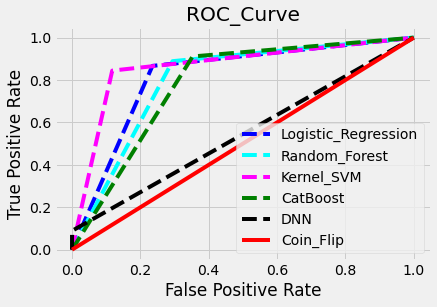

In [79]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [80]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [81]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [82]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.68    0.76      0.72    17.00
           1                  0.91    0.87      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.82      0.80    62.00
           weighted avg       0.85    0.84      0.84    62.00
RFC_Rep_df 0                  0.71    0.71      0.71    17.00
           1                  0.89    0.89      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.80      0.80    62.00
           weighted avg       0.84    0.84      0.84    62.00
KSV_Rep_df 0                  0.68    0.88      0.77    17.00
           1                  0.95    0.84      0.89    45.00
           accuracy           0.85    0.85      0.85     0.85
           macro avg          0.82    0.86      0.83    62.00
           weighted avg       0.88    0.85      0.86    62.00
CBC_Rep_df 0                  0.73    0.65      0.69    17.00
           1                  0.87    0.91      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.78      0.79    62.00
           weighted avg       0.83    0.84      0.84    62.00
DNN_Rep_df 0                  0.29    1.00      0.45    17.00
           1                  1.00    0.09      0.16    45.00
           accuracy           0.34    0.34      0.34     0.34
           macro avg          0.65    0.54      0.31    62.00
           weighted avg       0.81    0.34      0.24    62.00

### Iteration 4

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Upsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = ['lumbar_lordosis_angle', 'Direct_tilt', 'thoracic_slope', 'scoliosis_slope']
        - in other words, variables not making the top features cut from Decision Tree fit are dropped

Output:

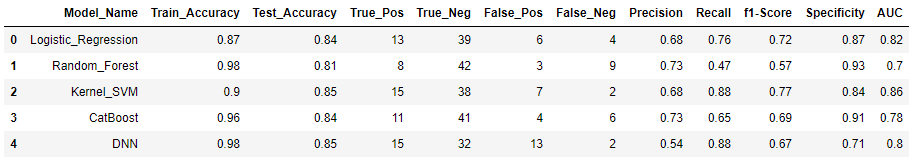
    
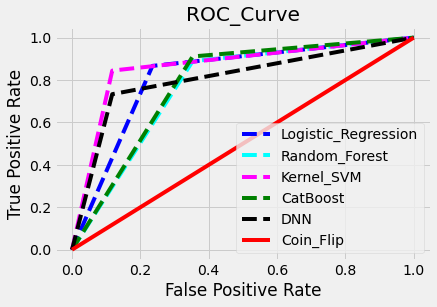

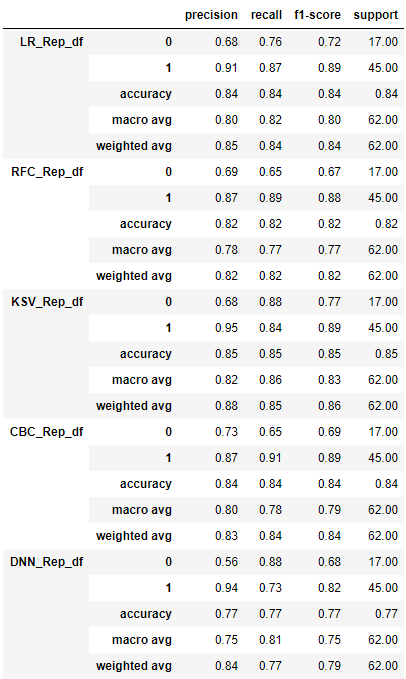

Conclusions & Recommendations:
    1. Recall has improved to 88 % which is thus far the best. (SVM Model)
    2. However, the difference in train and test accuracy is now 5%.

### Iteration 3

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Downsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = ['pelvic_incidence']

Output:

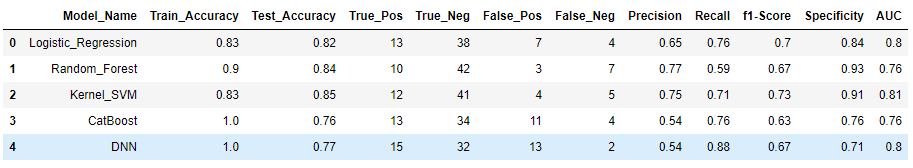

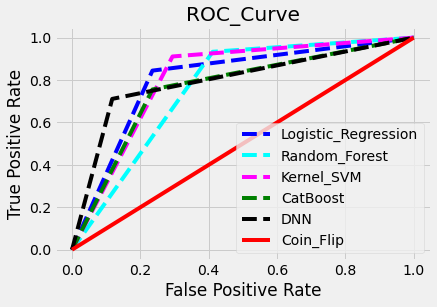

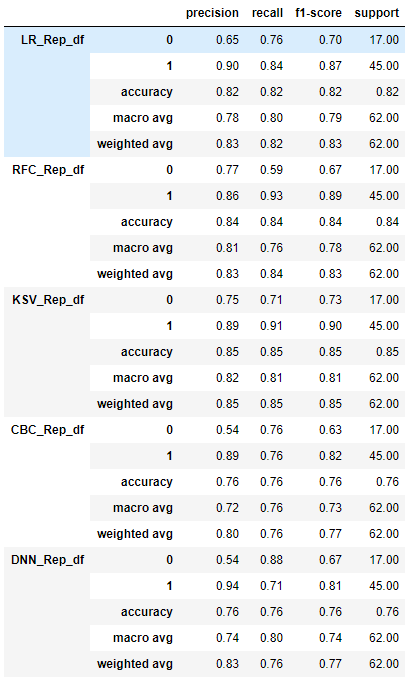

Conclusions / Recommendations:
    1. Downsampling not recommended. Recall has taken the turn for the worst.
    2. Iteration 3 will not be pursued further.
    3. Iteration # 2 will be the baseline against which improvement will be targeted.

### Iteration 2

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Upsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = ['pelvic_incidence']

Output:

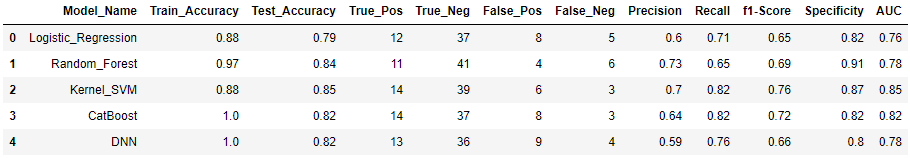

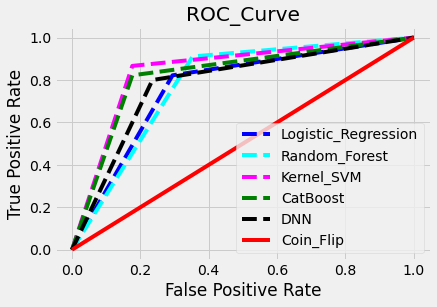

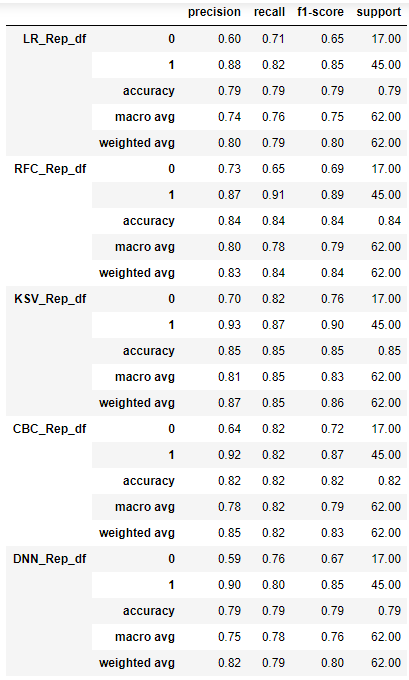

Conclusions / Recommendations:
    1. No significant impact of removing pelvic_incidence.
    2. Though recall for Catboost is higher than SVM, train and test accuracy differ by a large margin.
    3. Scores are below the target. Scope for improvement exists.

### Iteration 1

Description:
    1. Outliers removed? = No 
    2. Up / Down Sampling? = Upsampling.
    3. Standard / MinMax Scaler? = Standard
    4. Columns Dropped = []

Output:

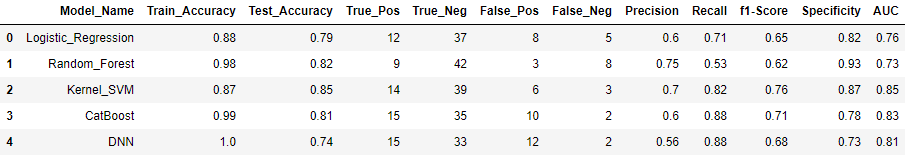

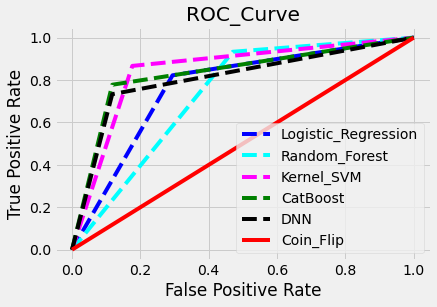

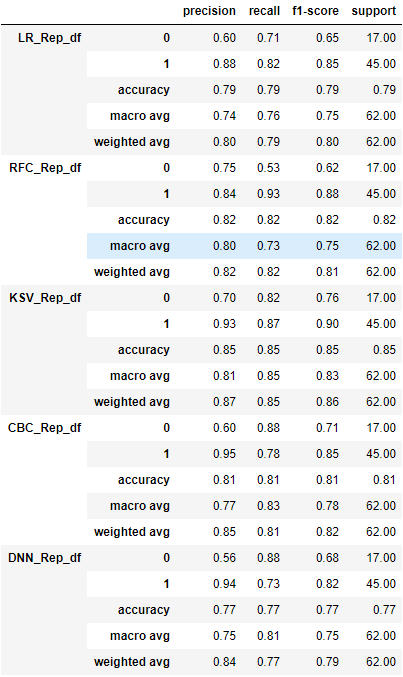

Conclusions / Recommendations:
    1. Objective of the project is to have the best recall and accuracy. Keeping this in mind, Kernel SVM seems better.
    2. Though recall for Catboost is higher than SVM, train and test accuracy differ by a large margin.
    3. Scores are below the target. Scope for improvement exists.

In [83]:
# !jupyter nbconvert --output-dir='C:\DSML_Case_Studies\01_Classification\00_Final_Reports' MLM_CLF_Dataset_Back_Pain_R1.ipynb --to html